In [1]:
# Before submission, set this to True so that you can render and verify this notebook without retraining all the deep learning models.
# All models will be loaded from file instead.
stop_training = False

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Uncomment the following line to run in Google Colab
!pip install --quiet openml 

     |████████████████████████████████| 112kB 9.1MB/s 


In [4]:
# Uncomment the following line to run in Google Colab
%tensorflow_version 2.x
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU') # Check whether GPUs are available

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
%matplotlib inline
import openml as oml
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [6]:
from packaging import version
import sklearn
import tensorflow
sklearn_version = sklearn.__version__
tensorflow_version = tensorflow.__version__
if version.parse(tensorflow_version) < version.parse("2.2.0"):
    print("Tensorflow is outdated. This is version {}. Please update to 2.2.".format(tensorflow_version))
else:
    print("Looks good. You may continue :)")

Looks good. You may continue :)


In [7]:
tensorflow_version

'2.3.0'

# Assignment 3

### Choice of libraries
We recommend to use Tensorflow in this assignment since that is what we covered in the labs. If you feel confident using PyTorch (and Skorch for the scikit-learn wrapper), that is allowed too, as long as you are able to implement the requested functions and return the requested data. Read the assignment carefully and ensure that you can. Note that you may also need to do a bit more work to implement certain helper functions and wrappers.

### Storing and submitting files
You must be able to store your models and submit them to GitHub Classroom. The evaluation functions used in this notebook will automatically store models for you. Be sure to upload all .h5 and .p files, as well as any .json files created (only for large models).

If you want to run and solve the notebook on your local machine/laptop, fill in the path 'base_dir' to your assignment folder into the next cell.

If you use Colab, we recommend that you link it to your Google Drive:  
* Upload the assignment folder to your Google Drive (+ New > Folder Upload)
* Open Colab in a browser, open the 'Files' menu in the left sidebar, and click 'Mount Drive'
  * At this point you may need to authenticate
* Fill in the path to your assignment folder below
  * It's likely '/content/drive/My Drive/assignment-3-name'

In [8]:
# Define where the models should be stored
base_dir = '/content/drive/My Drive/assignment-3-test'

In [9]:
#Uncomment to link Colab notebook to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Using GPUs
While you can solve this assignment on a CPU, using a GPU will speed things up training quite a bit. If you have a local GPU, you can use that. If you don't, we recommend Google Colab. When you are in Colab:
* In Runtime > Change runtime type, select the GPU under Hardware Accelerator
* Run the 3rd cell on the top of this notebook to check that the GPU is found.

Note that Colab may not always have GPUs ready all the time, and may deny you a GPU when you have used them a lot. When you are temporarily 'locked out', you can switch to a non-GPU runtime or to a local instance of Jupyter running on your machine.

### Constraints
* Your stored models should not be larger than 100MB when stored in file. GitHub will not allow uploading if they are. We provide code below that stores the model efficiently. Smaller models are simply stored entirely to disk as one h5 file. For larger models, we will only store the weights (h5 file) and structure (json file), and ignore the state of the optimizer. In any case, the weights alone should not take more than 100MB of storage.
* When questions ask you to provide an explanation, it should be less than 800
characters long. Some questions have a higher limit. Always answer in full sentences.
* Don't train for more than 100 epochs, i.e. don't throw excessing computational resources at the problem. If your model hasn't converged by then, think of ways it could be made to converge faster. In this assignment you are not after the last tiny improvement, you can stop when learning curves flatten out. Do at least 5 epochs to get a reasonable learning curve.

### Grading
Grading is based on the following aspects:
* Correctness in answering the question. Carefully read the question and answer
what is asked for. Train your models on the correct data. It should be clear on which data should be trained, but ask when in doubt. When something is not defined (e.g. the number of epochs or batch size), you can freely choose them.
* Clarity of your explanations. Write short but precise descriptions of what you did and why. Give short but clear explanations of the observed performance. 
After your explanation, your approach and model should make perfect sense. Refrain from using symbols as substitute for words in your explanation (e.g. no: "More layers -> more parameters" yes: "More layers mean more parameters"). 
* Part of your grade depends on how well your model performs. When the question says 'you should at least get x%', x% will give you a good but not the maximal grade. You can get the full grade when you are close to what is the expected maximal performance. You don't need to invest lots of effort into the last tiny improvement, though. Unless specified, we look at the accuracy on the validation set. If your learning curves are very erratic we'll compute a score based on the smoothed curves (i.e. single peaks don't count).
* The weight of each question is indicated. Take this into account when planning your time.

### Other tips
* Don't wait until the last minute to do the assignment. The models take time to train, most questions will require some thinking, and some require you to read up on some new concepts.
* Take care that you upload the results as requested. You need to submit not only the notebooks but also the trained models and learning curves (training histories). Be sure to run the verification script and check that all the results are included.
* We provide an evaluation function that also stored models to disk. After you are done training the model, set the 'train' attribute to False so that the model doesn't train again (and loads from file instead) when you restart and rerun your notebook.
* Explore. For many questions we'll ask you to explain your model design decisions. You cannot magically know the best solutions but you can experiment
based on your understanding and make decisions based on both your knowledge and experiments. Your explanation is at least as important as the performance of your model.
* **Be original. We will check for plagiarism between student submissions, also those of previous assignments.**

### Data
The [STL-10](https://www.openml.org/d/41103) dataset contains 96-by-96 RGB images of 10 types of objects (airplanes, birds, cats,...). Your goal is to build models that recognize the correct object in each image.

If you use Colab, uncomment the following to cache the dataset inside the VM. This will make reloading faster if you need to restart your notebook. After longer periods of inactivity, your VM may be recycled and the cache lost, in which case the dataset will be downloaded again. Also note that this dataset is about 1Gb large, and will take even more space in memory. You may need to switch to a high-RAM environment (Colab will ask you if you hit the limit).

In [10]:
# Uncomment to use OpenML caching in Colab
# On your local machine, it will store data in a hidden folder '~/.openml'
import os
oml.config.cache_directory = os.path.expanduser('/content/cache')

In [11]:
# Download STL-10 data. Takes a while (several minutes), and quite a bit of
# memory when it needs to download. After caching it loads faster.
STL = oml.datasets.get_dataset(41103)
X, y, _, _ = STL.get_data(dataset_format='array',
    target=STL.default_target_attribute)
class_names = ["airplane", "bird", "car", "cat", "deer", "dog", "horse", "monkey", "ship", "truck"]

Reshape, sample and split the data

In [12]:
from tensorflow.keras.utils import to_categorical

Xr = X.reshape((len(X),96,96,3))
Xr = Xr / 255.
yr = to_categorical(y)

In [13]:
# DO NOT EDIT. DO NOT OVERWRITE THESE VARIABLES.
from sklearn.model_selection import train_test_split
# We do an 80-20 split for the training and test set, and then again a 80-20 split into training and validation data
X_train_all, X_test, y_train_all, y_test = train_test_split(Xr,yr, stratify=yr, train_size=0.8, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_all,y_train_all, stratify=y_train_all, train_size=0.8, random_state=1)
evaluation_split = X_train, X_val, y_train, y_val

Check the formatting - and what the data looks like

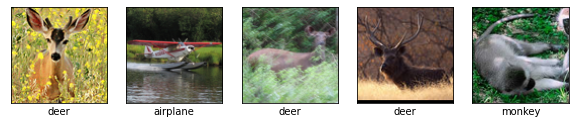

In [14]:
from random import randint

# Takes a list of row ids, and plots the corresponding images
# Use grayscale=True for plotting grayscale images
def plot_images(X, y, grayscale=False):
    fig, axes = plt.subplots(1, len(X),  figsize=(10, 5))
    for n in range(len(X)):
        if grayscale:
            axes[n].imshow(X[n], cmap='gray')
        else:
            axes[n].imshow(X[n])
        axes[n].set_xlabel(class_names[np.argmax(y[n])])
        axes[n].set_xticks(()), axes[n].set_yticks(())
    plt.show();

images = [randint(0,len(X_train)) for i in range(5)]
X_random = [X_train[i] for i in images]
y_random = [y_train[i] for i in images]
plot_images(X_random, y_random)

### Evaluation harness
We provide an evaluation function 'run_evaluation' that you should use to 
evaluate all your models. It also stores the trained models to disk so that
your submission can be quickly verified, as well as to avoid having to train
them over and over again. Your last run of the evaluation function (the last one
stored to file), is the one that will be evaluated. The 'train' argument indicates whether to train or to load from disk. We have provided helper functions for saving and loading models to/from file, assuming you use TensorFlow. If you use PyTorch you'll have to adapt them.

In [15]:
import os
import pickle
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model # for use with tensorflow
from tensorflow.keras.models import model_from_json
import pydot
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import inspect
from IPython.core import page
page.page = print

# Helper function for user feedback
def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')
        
# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

# Helper function to format answers
def print_answer(ans):
    output = ""
    for line in ans.splitlines()[0:]:
        output += line.strip() + " "
    output += "(length: "+str(len(output))+")\n"
    print(output)
    

def load_model_from_file(base_dir, name, extension='.h5'):
    """ Loads a model from a file. The returned model must have a 'fit' and 'summary'
    function following the Keras API. Don't change if you use TensorFlow. Otherwise,
    adapt as needed. 
    Keyword arguments:
    base_dir -- Directory where the models are stored
    name -- Name of the model, e.g. 'question_1_1'
    extension -- the file extension
    """
    try:
        # if a json description is available, load config and then weights
        if os.path.isfile(os.path.join(base_dir, name+'.json')):
            json_file = open(os.path.join(base_dir, name+'.json'), 'r')
            loaded_model_json = json_file.read()
            json_file.close()
            model = model_from_json(loaded_model_json)
            model.load_weights(os.path.join(base_dir, name+extension))
        # else just load the entire model from hdf5 file
        else:
            model = load_model(os.path.join(base_dir, name+extension))
    except OSError:
        shout("Saved model could not be found. Was it trained and stored correctly? Is the base_dir correct?")
        return False
    return model

def save_model_to_file(model, base_dir, name, extension='.h5'):
    """ Saves a model to file. Don't change if you use TensorFlow. Otherwise,
    adapt as needed.
    Keyword arguments:
    model -- the model to be saved
    base_dir -- Directory where the models should be stored
    name -- Name of the model, e.g. 'question_1_1'
    extension -- the file extension
    """
    path = os.path.join(base_dir, name+extension)
    model.save(path)
    size = os.path.getsize(path)
    # If model > 100MB, store the weights and architecture only.
    if size > 100*1024*1024:
        print("Model larger than 100MB, storing weights only.")
        model.save_weights(path)
        model_json = model.to_json()
        with open(os.path.join(base_dir, name+".json"), "w") as json_file:
            json_file.write(model_json)

# Evaluation harness
def run_evaluation(name, model_builder, data, base_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, print_model=True, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data is given as a generator or not. Set batch size to None when using a generator.
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with. Set batch size to None when using a generator.
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    print_model -- whether or not to print the model
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}
    if train and not stop_training: # Train anew
        shout("Training the model", verbose)
        if generator:
            generator, X_val, y_val = data
            history = model.fit(generator, epochs=epochs, batch_size=batch_size,
                              steps_per_epoch=steps_per_epoch, verbose=1, 
                              validation_data=(X_val, y_val))
            learning_curves = history.history
        else:
            X_train, X_val, y_train, y_val = data
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                              verbose=1, validation_data=(X_val, y_val))
            learning_curves = history.history
        shout("Saving to file", verbose)
        save_model_to_file(model, base_dir, name)
        with open(os.path.join(base_dir, name+'.p'), 'wb') as file_pi:
            pickle.dump(learning_curves, file_pi)
        shout("Model stored in "+base_dir, verbose)
    else: # Load from file
        model = load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
            return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
            return
    # Report
    lc = pd.DataFrame(learning_curves)
    print("Max val score: {:.2f}%".format(lc.iloc[:,3].max()*100))
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    plt.show()
    
    if print_model:
        print(model.summary())
    plot_model(model, to_file=os.path.join(base_dir,name+'.png'))

Training the model
Epoch 1/3
260/260 [==============================] - 1s 4ms/step - loss: 2.3347 - accuracy: 0.0974 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 2/3
260/260 [==============================] - 1s 3ms/step - loss: 2.3028 - accuracy: 0.0929 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 3/3
260/260 [==============================] - 1s 3ms/step - loss: 2.3028 - accuracy: 0.0959 - val_loss: 2.3026 - val_accuracy: 0.1000
Saving to file
Model stored in /content/drive/My Drive/assignment-3-test
Max val score: 10.00%


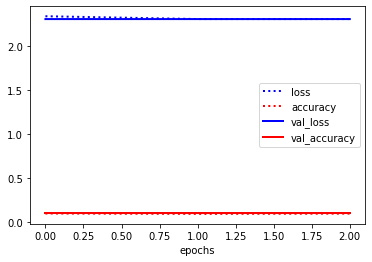

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 27648)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                276490    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
Total params: 276,600
Trainable params: 276,600
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
# Toy usage example
from tensorflow.keras import models
from tensorflow.keras import layers 

def build_toy_model():
    model = models.Sequential()
    model.add(layers.Reshape((27648,), input_shape=(96,96,3)))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# First build and store
run_evaluation("toy_example", build_toy_model, evaluation_split, base_dir, 
               train=True, epochs=3, batch_size=32)

Max val score: 10.00%


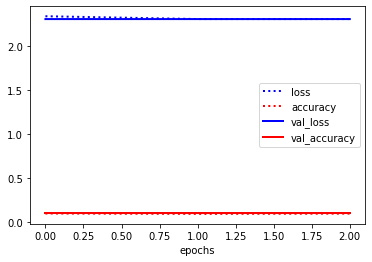

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 27648)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                276490    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
Total params: 276,600
Trainable params: 276,600
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
# Toy usage example
# With train=False: load from file and report the same results without rerunning
run_evaluation("toy_example", build_toy_model, evaluation_split, base_dir, 
               train=False)

## Part 1. Dense networks (8 points)

### Question 1: Baseline model (8 points)
- Build a dense network (with only dense layers) of at least 3 layers. Implement a function 'build_model_1' that returns this model.
- You can explore different architectures and tune the model. Also explore (and combine) different regularization techniques, activation functions, and optimizers. What works best? How are your decisions influenced by the properties of the data.
* Tune other hyperparameters (e.g. learning rate, batch size, number of epochs,...) as you see fit. Explain the effects.
* Explain your findings and design decisions in 'answer_q_1'. What did you try, and why, whether it worked and if not, why not? You are allowed **1000** characters for this answer (but don’t ramble).
* Remember to keep your final model below 100MB in size.

Training the model
Epoch 1/80
130/130 [==============================] - 1s 8ms/step - loss: 6.2325 - accuracy: 0.2215 - val_loss: 4.8113 - val_accuracy: 0.2856
Epoch 2/80
130/130 [==============================] - 1s 7ms/step - loss: 4.1338 - accuracy: 0.2930 - val_loss: 3.7006 - val_accuracy: 0.2683
Epoch 3/80
130/130 [==============================] - 1s 7ms/step - loss: 3.4224 - accuracy: 0.3200 - val_loss: 3.2819 - val_accuracy: 0.3173
Epoch 4/80
130/130 [==============================] - 1s 7ms/step - loss: 3.1328 - accuracy: 0.3337 - val_loss: 3.1032 - val_accuracy: 0.3048
Epoch 5/80
130/130 [==============================] - 1s 7ms/step - loss: 2.9312 - accuracy: 0.3494 - val_loss: 2.9128 - val_accuracy: 0.3173
Epoch 6/80
130/130 [==============================] - 1s 7ms/step - loss: 2.7762 - accuracy: 0.3576 - val_loss: 2.7225 - val_accuracy: 0.3601
Epoch 7/80
130/130 [==============================] - 1s 7ms/step - loss: 2.6260 - accuracy: 0.3746 - val_loss: 2.6120 - val_accu

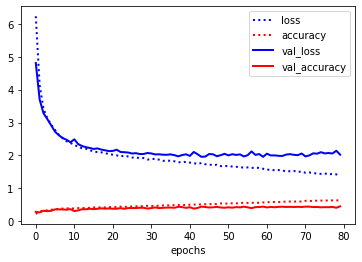

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 27648)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               7078144   
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 10)               

In [18]:
from keras import regularizers
from tensorflow.keras import optimizers


def build_model_1():
    model = models.Sequential()
    model.add(layers.Reshape((27648,), input_shape=(96,96,3)))
    model.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.0001), activation='relu'))
    model.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.0001), activation='relu'))
    model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
    model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
    model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


run_evaluation("model_1", build_model_1, evaluation_split, base_dir, 
               train=True, epochs=80, batch_size=64)

answer_q_1 = """

A five layers network is constructed. Since the input dimension is very high, the first layer has 256 units. 
The second layer has 256 units while the rest layers have 64 units. Learning rate is 0.0001 and batch 
size is 64. It is noted that there are many learnable parameters and it is easy to be overfitting. Several tools have 
been tried to reduce the complexity of model. In the first and second layer the l1 regularization is tried to make them 
sparse. And l2 is utilized for other layers. BN layer and dropout are tried but the network converges slowly. 
When learning rate is larger, accuracy becomes oscillation and batch size is appropriate for randomness and gradients calculation. 
The performance is not good and it is difficult for a model to perform well with only dense layers.

"""
print("Answer is {} characters long".format(len(answer_q_1)))

## Part 2. Convolutional neural networks (12 points)
### Question 2.1: Design a ConvNet (8 points)
- Build a sequential convolutional neural network. Try to achieve the best validation accuracy you can. You should be able to get at least 70% accuracy. 80% or more is also possible. You can use any depth, any combination of layers, and any kind of regularization and tuning. You can use different batch sizes and number of epochs as in question 1.
- Add a description of your design choices in 'answer_q_2_1': explain what you did and also why. Also discuss the performance of the model. Is it working well? Both the performance of the model and your explanations matter.
- Explictly explore different filter sizes and padding techniques. Explain what the effect is, also in relationship with the layer input sizes.
- You are allowed **1000** characters for this answer (but don’t ramble).
- The name of the model should be 'model_2_1'. Evaluate it using the 'run_evaluation' function and the preprocessed data.

Training the model
Epoch 1/80
  2/130 [..............................] - ETA: 5s - loss: 4.5360 - accuracy: 0.2109WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0090s vs `on_train_batch_end` time: 0.0697s). Check your callbacks.


130/130 [==============================] - 11s 85ms/step - loss: 3.0491 - accuracy: 0.3841 - val_loss: 16.9803 - val_accuracy: 0.1101
Epoch 2/80
130/130 [==============================] - 11s 83ms/step - loss: 2.8049 - accuracy: 0.4605 - val_loss: 3.7641 - val_accuracy: 0.2909
Epoch 3/80
130/130 [==============================] - 11s 83ms/step - loss: 2.2029 - accuracy: 0.5660 - val_loss: 2.0949 - val_accuracy: 0.5788
Epoch 4/80
130/130 [==============================] - 11s 83ms/step - loss: 1.8412 - accuracy: 0.6294 - val_loss: 1.9851 - val_accuracy: 0.5817
Epoch 5/80
130/130 [==============================] - 11s 83ms/step - loss: 1.6028 - accuracy: 0.6770 - val_loss: 1.5833 - val_accuracy: 0.6721
Epoch 6/80
130/130 [==============================] - 11s 84ms/step - loss: 1.5484 - accuracy: 0.6958 - val_loss: 1.7032 - val_accuracy: 0.6606
Epoch 7/80
130/130 [==============================] - 11s 83ms/step - loss: 1.4084 - accuracy: 0.7388 - val_loss: 1.6236 - val_accuracy: 0.6721
Ep

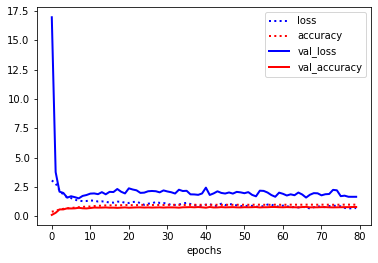

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 128)      

In [19]:
from keras import regularizers
from tensorflow.keras import optimizers

def build_model_2_1():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 3), kernel_initializer= "he_normal", activation='relu', padding="same", input_shape=(96,96,3)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), kernel_initializer= "he_normal", activation='relu', padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2), strides=(2,2)))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(128, (3, 3), kernel_initializer= "he_normal", activation='relu', padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), kernel_initializer= "he_normal", activation='relu', padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2), strides=(2,2)))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(256, (3, 3), kernel_initializer= "he_normal", activation='relu', padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(256, (3, 3), kernel_initializer= "he_normal", activation='relu', padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2), strides=(2,2)))
    model.add(layers.Dropout(0.2))


    model.add(layers.Conv2D(512, (3, 3), kernel_initializer= "he_normal", activation='relu', padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(512, (3, 3), kernel_initializer= "he_normal", activation='relu', padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2), strides=(2,2)))
    model.add(layers.Dropout(0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer=optimizers.Adam(
        learning_rate=0.001), loss='categorical_crossentropy',metrics=['accuracy'])
    return model


run_evaluation("model_2_1", build_model_2_1, evaluation_split, base_dir, 
               train=True, epochs=80, batch_size=64)


answer_q_2_1 = """

A VGG-like network is designed and trained. The model has four blocks of 2 convolutional layers with maxpooling, batch normalization and dropout in between. 
BN layers help the network converge faster and dropout is used for regularization. The channels in each block are same and double when switching to another 
block. Zero-padding is applied to avoid shrinking the tensors too fast. The last layer in the model is a fully connected layer. This a mlticlassification 
task so the softmax activation function is utilized in the output layer. Batch size is set to be 64 and learning rate is 0.001. The network has been trained 
for 80 epochs under the supervision of Adam optimizer. The performances on training set and validation set are higher than 70%. The model is good and performs well. 

"""
print("Answer is {} characters long".format(len(answer_q_2_1)))

### Question 2.2: Data Augmentation (4 points)

- Augment the preprocessed training data. You can explore using image shifts, rotations, zooming, flips, etc. What works well, and what does not? Reason
about what might work or not on these images.
- Evaluate the model from question 2.1 with the augmented data using the 'run_evaluation' function. Store the new trained model as 'model_2_2'.
- Add a description of your design choices in 'answer_q_2_2': explain what you did and also why. Also discuss the performance of the model.

Training the model
Epoch 1/100
130/130 [==============================] - ETA: 0s - loss: 3.2997 - accuracy: 0.3305WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0025s vs `on_test_batch_end` time: 0.0096s). Check your callbacks.


130/130 [==============================] - 18s 135ms/step - loss: 3.2997 - accuracy: 0.3305 - val_loss: 4.2712 - val_accuracy: 0.2313
Epoch 2/100
130/130 [==============================] - 17s 130ms/step - loss: 2.8721 - accuracy: 0.4119 - val_loss: 3.8229 - val_accuracy: 0.2635
Epoch 3/100
130/130 [==============================] - 17s 130ms/step - loss: 2.4672 - accuracy: 0.4897 - val_loss: 2.1835 - val_accuracy: 0.5524
Epoch 4/100
130/130 [==============================] - 17s 128ms/step - loss: 2.1023 - accuracy: 0.5383 - val_loss: 1.8569 - val_accuracy: 0.5962
Epoch 5/100
130/130 [==============================] - 17s 131ms/step - loss: 1.8992 - accuracy: 0.5715 - val_loss: 1.6569 - val_accuracy: 0.6399
Epoch 6/100
130/130 [==============================] - 17s 129ms/step - loss: 1.6958 - accuracy: 0.6108 - val_loss: 1.5555 - val_accuracy: 0.6519
Epoch 7/100
130/130 [==============================] - 17s 129ms/step - loss: 1.6007 - accuracy: 0.6260 - val_loss: 1.7613 - val_accurac

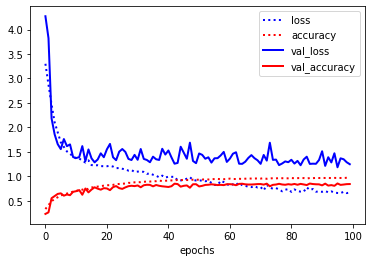

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 96, 96, 64)        1792      
_________________________________________________________________
batch_normalization_9 (Batch (None, 96, 96, 64)        256       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 96, 96, 64)        36928     
_________________________________________________________________
batch_normalization_10 (Batc (None, 96, 96, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 48, 48, 128)      

In [20]:
# Note that we build the same untrained model as in question 2.1 but store the 
# trained version as model_2_2. Change attributes as needed to run on augmented
# data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

augmented_split = evaluation_split # replace with your augmented data

X_train_pre, X_val_pre, y_train_pre, y_val_pre = augmented_split


train_datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
it_train = train_datagen.flow(X_train_pre, y_train_pre, batch_size=64)


augmented_split = it_train, X_val_pre, y_val_pre

run_evaluation("model_2_2", build_model_2_1, augmented_split, base_dir, train=True, generator=True, epochs=100, batch_size=None, steps_per_epoch=X_train_pre.shape[0]//64)


answer_q_2_2 = """

We use width and height shift, horizontal flip, zoom for data augmentation. It is concluded that the model shows better performancce
on validation set. We use random shift since the network should be able to classify the object in an image even though there is a small shift. 
Also, horizontal should be helpful because we want the model to be able to recognize the object with horiontal flip in an image. In addition, we 
tried random rotation however it is not helpful in this task. Random zoom is utilized since the network can classify the same object whenever it is 
larger or smaller in an image. It is illustrated that the methods of data augmentation has helped the model to achieve accuracy above 80% on 
on validation set, which is 3% to 5% higher than the results obtained on original dataset.
              
"""

print("Answer is {} characters long".format(len(answer_q_2_2)))

## Part 3. Model interpretation (10 points)
### Question 3.1: Interpreting misclassifications (2 points)
Study which errors are still made by your last model (model_2_2) by evaluating it on the test data. You do not need to retrain the model.
* What is the accuracy of model_2_2 on the test data? Store this in 'test_accuracy_3_1'.
* Plot the confusion matrix in 'plot_confusion_matrix' and discuss which classes are often confused.
* Visualize the misclassifications in more depth by focusing on a single
class (e.g. the number '2') and analyse which kinds of mistakes are made for that class. For instance, are the errors related to the background, noisiness, etc.? Implement the visualization in 'plot_misclassifications'. This is more of an open question. For instance, you could focus on the misclassifications for a single class. You should not simply print all misclassifications without good reason.
* Summarize your findings in 'answer_q_3_1'

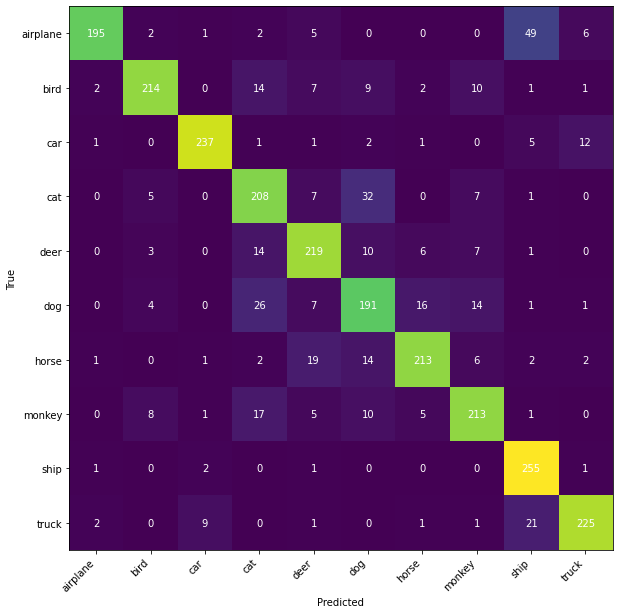

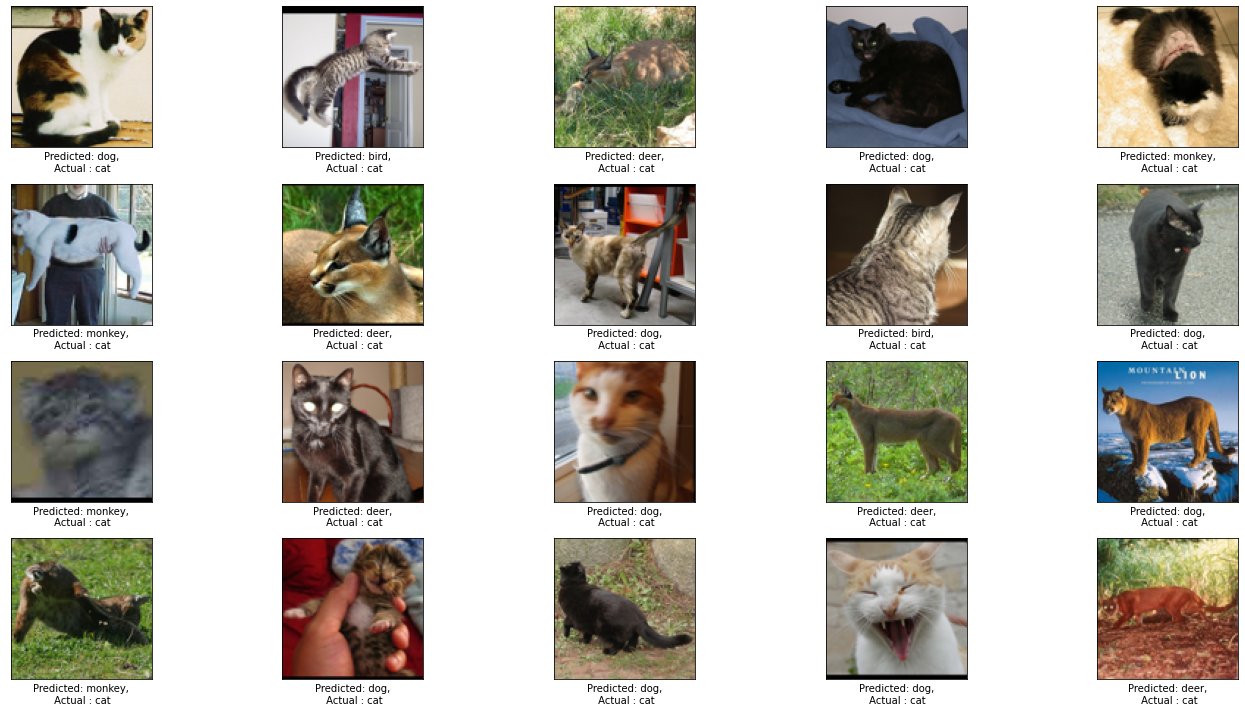

In [21]:
from sklearn.metrics import confusion_matrix


model_2_2 = load_model_from_file(base_dir, "model_2_2")
y_pred = model_2_2.predict(X_test)


stl_classes = {0: "airplane", 1: "bird", 2: "car", 3: "cat", 4:"deer", 5: "dog", 6: "horse", 7: "monkey", 8: "ship", 9: "truck"}
misclassified_samples = np.nonzero(np.argmax(y_test, axis=1) != np.argmax(y_pred, axis=1))[0]


onelist = []
for nr, i in enumerate(misclassified_samples):
    temp_label = y_test[i]
    if np.argmax(temp_label) == 3:
        onelist.append(i)


test_accuracy_3_1 = 0.843

def plot_confusion_matrix():
    cm = confusion_matrix(np.argmax(y_test, axis=1),np.argmax(y_pred, axis=1))
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm)
    ax.set_xticks(np.arange(10)), ax.set_yticks(np.arange(10))
    ax.set_xticklabels(list(stl_classes.values()), rotation=45, ha="right")
    ax.set_yticklabels(list(stl_classes.values()))
    ax.set_ylabel('True')
    ax.set_xlabel('Predicted')
    for i in range(100):
        ax.text(int(i/10),i%10,cm[i%10,int(i/10)], ha="center", va="center", color="w")




def plot_misclassifications():
    fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 10))
    for nr, i in enumerate(onelist[:20]):
        row = nr//5
        col = nr%5
        axes[row][col].imshow(X_test[i])
        axes[row][col].set_xlabel("Predicted: %s,\n Actual : %s" % (stl_classes[np.argmax(y_pred[i])], stl_classes[np.argmax(y_test[i])]))
        axes[row][col].set_xticks(()), axes[row][col].set_yticks(())
    plt.tight_layout()


plot_confusion_matrix()
plot_misclassifications()


answer_q_3_1 = """

Most misclassifications seem to involve car, cat, dog and horses. The most common misclassification is between cats and dogs.
In order to visualize the misclassifications and find reasons of errors, we take class "cat" as an example. We illustrate 20 samples of cat 
images which are mis-classified to other labels. Among the 20 images, 11 cat samples are misclassified to dog. It can be concluded that this
error is attributed to similar appearance of cats and dogs. In addition, if there is some occlusion in the image, it is easier to be misclssified.
For example, the second image in the first row, the cat is hidden behind the grass, so it is misclassified. Also, when the object in the image 
stays at a high place, it becomes a bit difficult for the network to recoginize. For example, the third image in the fourth row, the cat stays 
at a high place and the sky is captred in the image and then it is misclassified to be a bird.
               
"""

### Question 3.2: Visualizing activations (4 points)
* Select the **third** example from the test set (index 2, it should be a bird). Retrieve and visualize the activations (feature maps) of model 2_2 for that example, for every filter for different convolutional layers (at different depths in the network). Implement a function `plot_activations()` that returns the most interesting activations.
* Give an explanation (as detailed as you can) about your observations in 'answer_q_3_2'. Is your model indeed learning something useful?

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


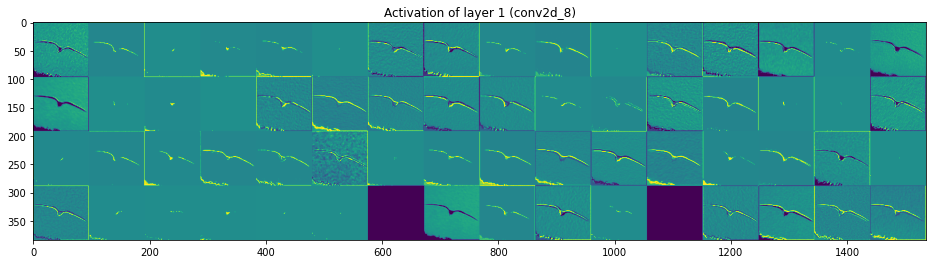

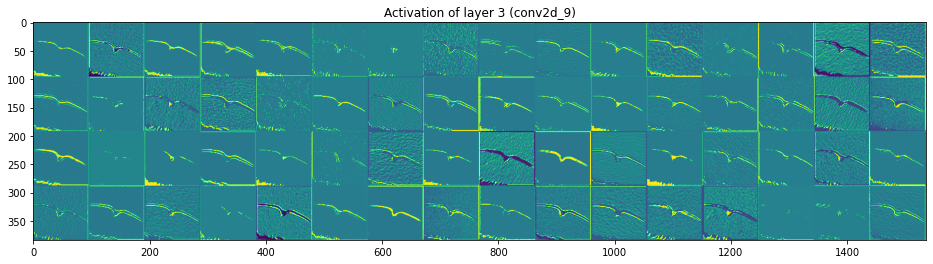

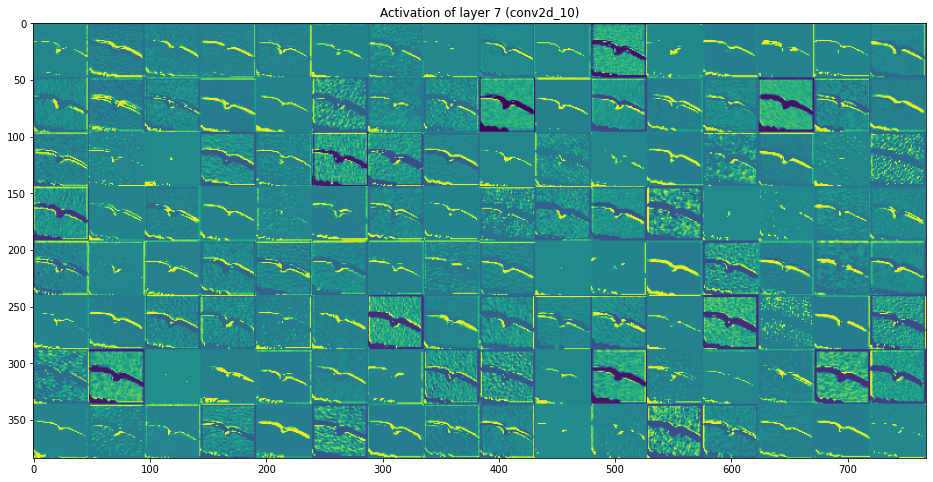

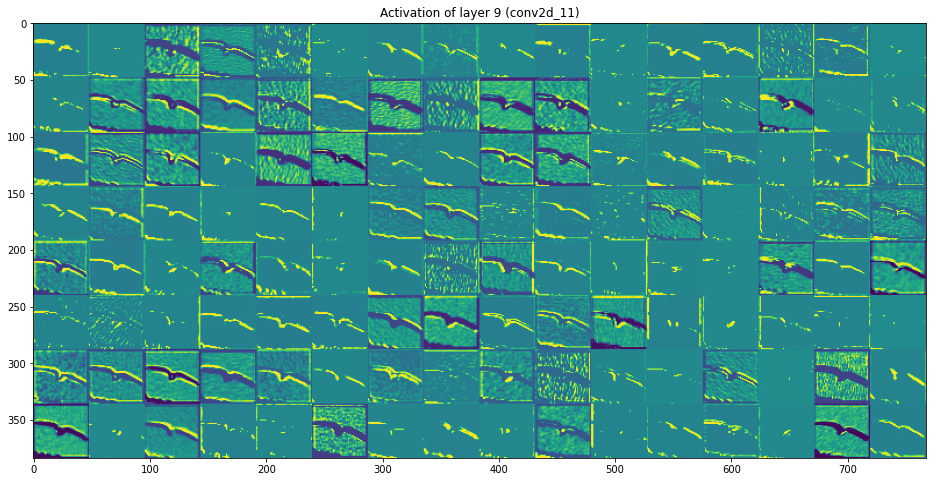

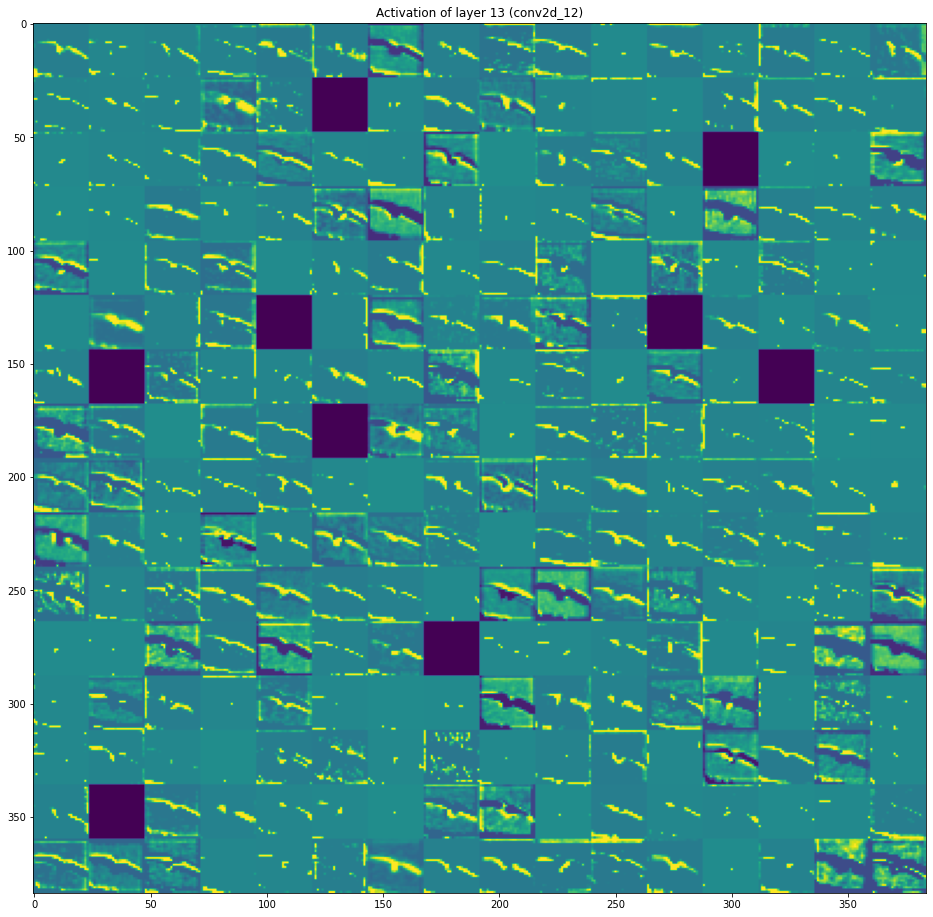

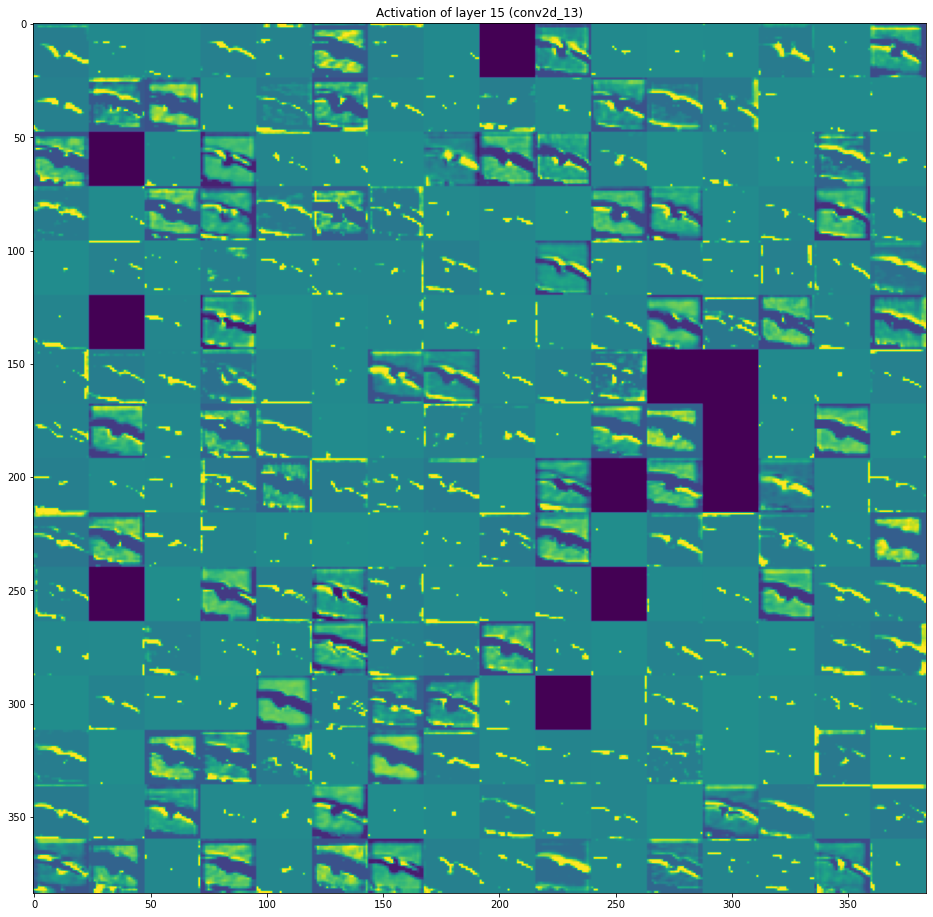

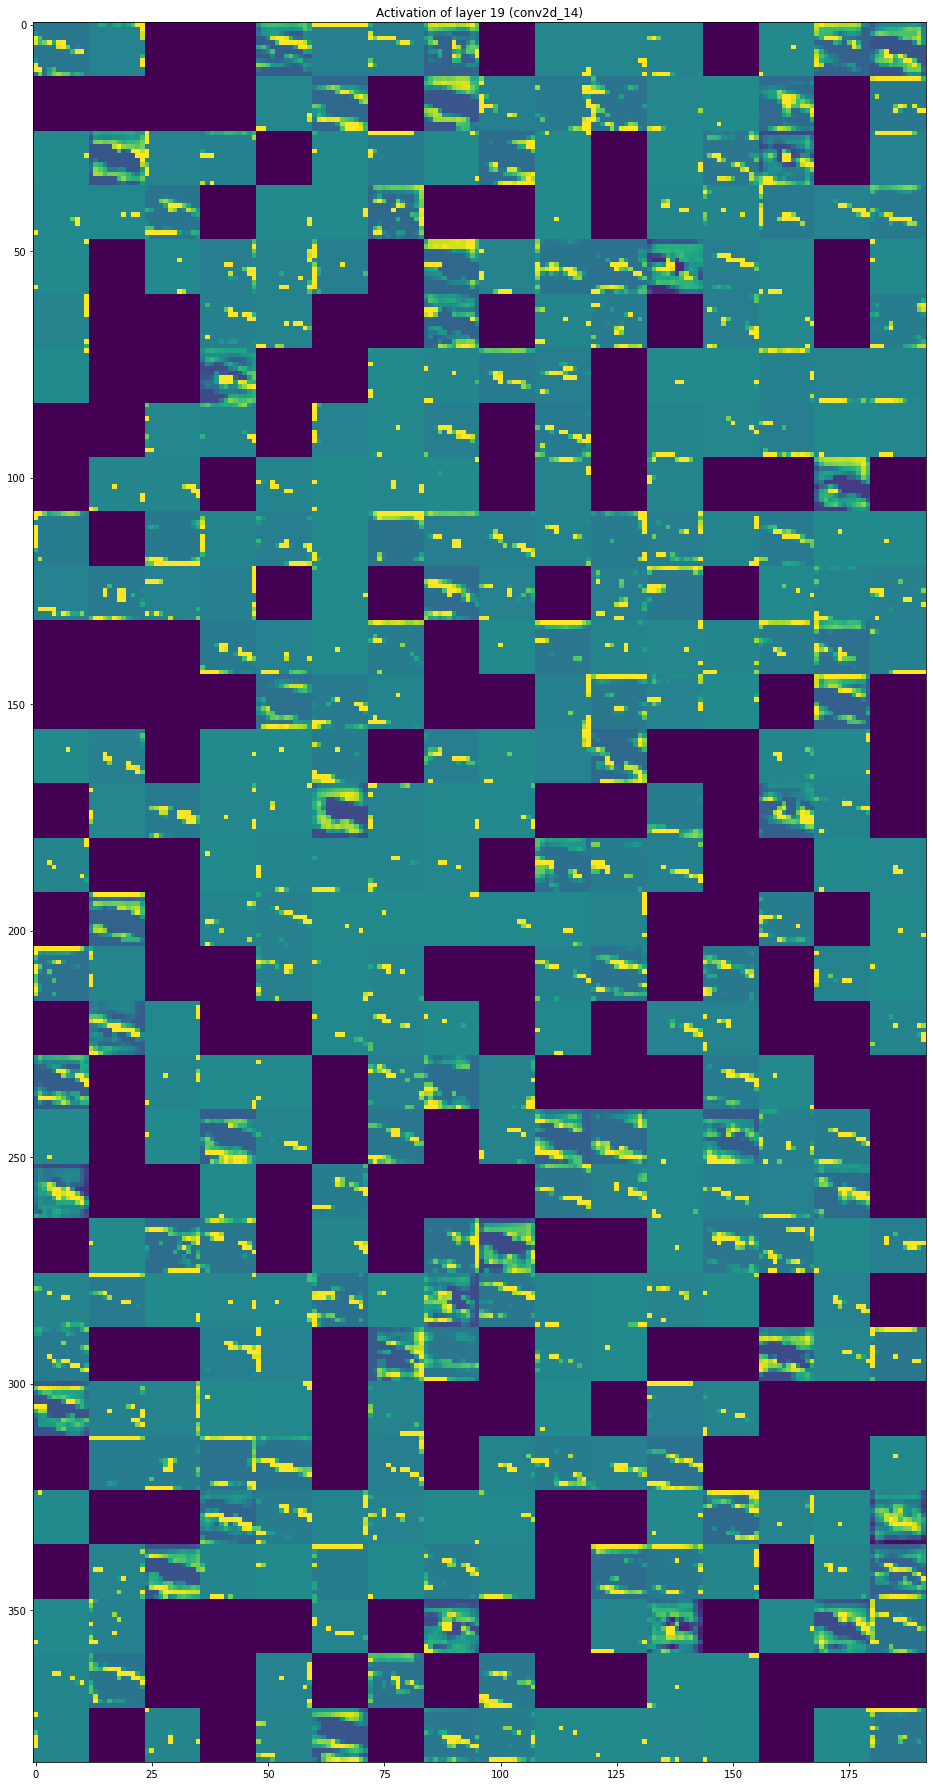

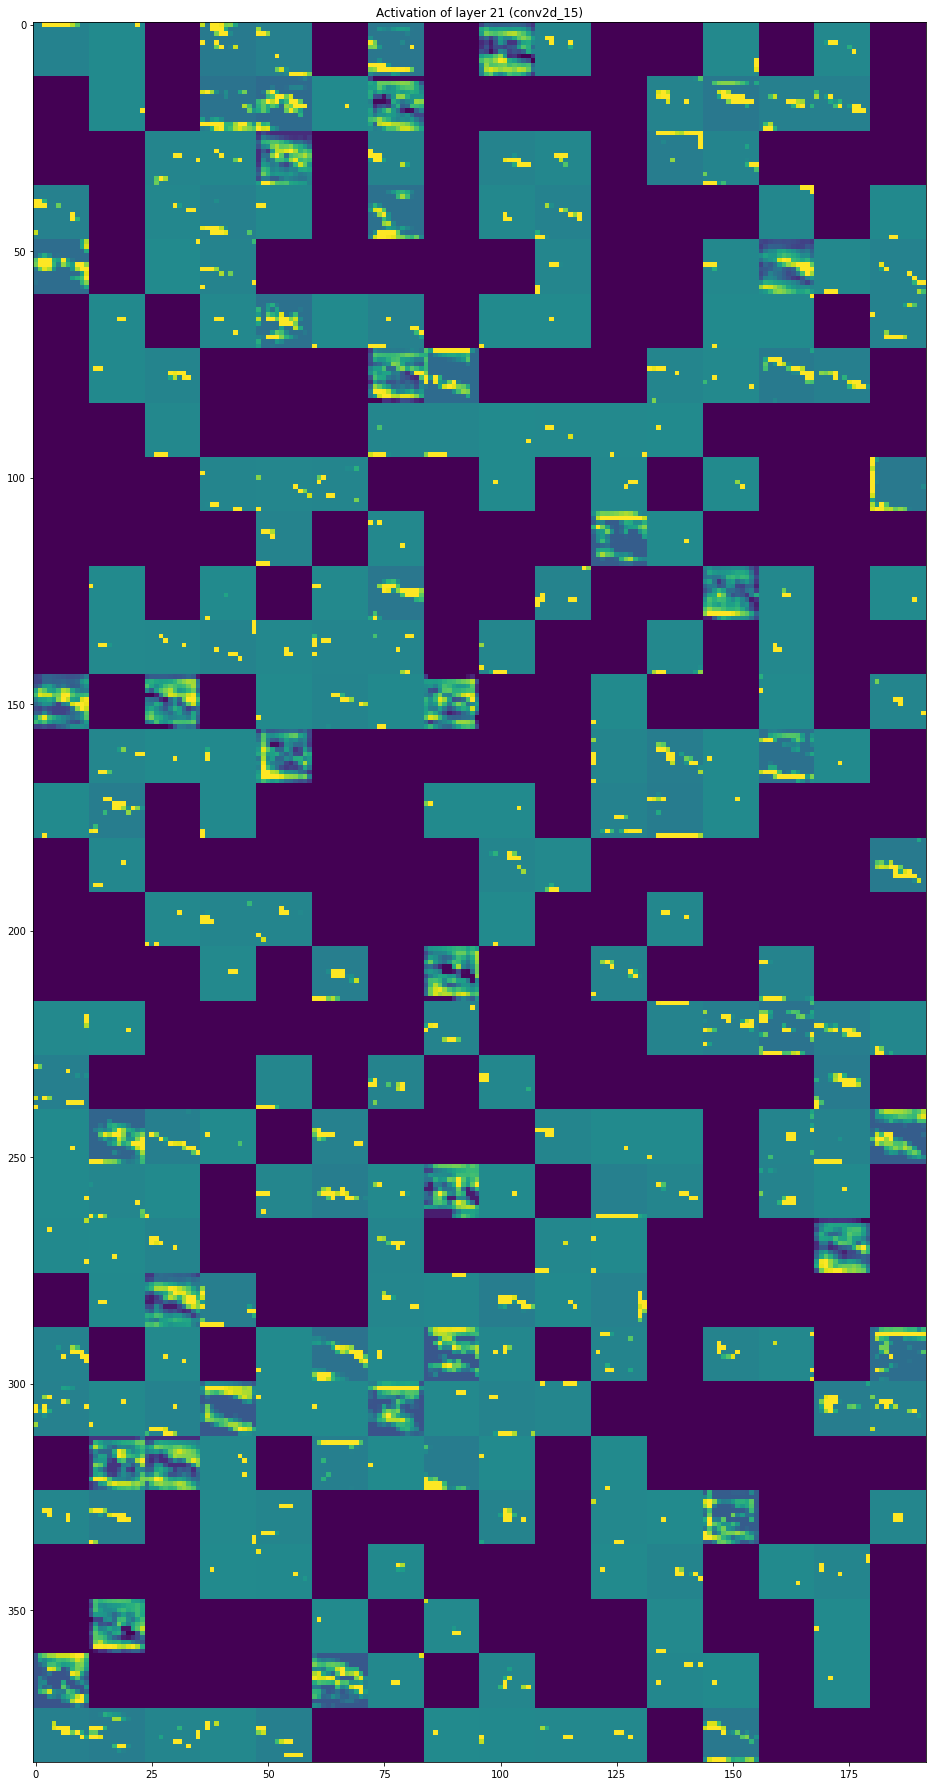

In [22]:
images_per_row = 16

def plot_activations():
    model_2_2 = load_model_from_file(base_dir, "model_2_2")
    layer_names = []
    for layer in model_2_2.layers[:21]:
        layer_names.append(layer.name)
    img_tensor = X_test[2]
    img_tensor = np.expand_dims(img_tensor, axis=0) 
    layer_outputs = [layer.output for layer in model_2_2.layers[:21]]
    activation_model = models.Model(inputs=model_2_2.input, outputs=layer_outputs)
    activations = activation_model.predict(img_tensor)

    layer_indexes = [0,2,6,8,12,14,18,20]
    for layer_index in layer_indexes:
        start = layer_index
        end = layer_index+1

        # Now let's display our feature maps
        for layer_name, layer_activation in zip(layer_names[start:end], activations[start:end]):
            # This is the number of features in the feature map
            n_features = layer_activation.shape[-1]

            # The feature map has shape (1, size, size, n_features)
            size = layer_activation.shape[1]

            # We will tile the activation channels in this matrix
            n_cols = n_features // images_per_row
            display_grid = np.zeros((size * n_cols, images_per_row * size))

            # We'll tile each filter into this big horizontal grid
            for col in range(n_cols):
                for row in range(images_per_row):
                    channel_image = layer_activation[0, :, :, col * images_per_row + row]
                    # Post-process the feature to make it visually palatable
                    channel_image -= channel_image.mean()
                    channel_image /= channel_image.std()
                    channel_image *= 64
                    channel_image += 128
                    channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                    display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image

            # Display the grid
            scale = 1. / size
            plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
            plt.title("Activation of layer {} ({})".format(layer_index+1,layer_name))
            plt.grid(False)
            plt.imshow(display_grid, aspect='auto', cmap='viridis')
        plt.show()

plot_activations()


answer_q_3_2 =  """
                There are eight convolutional layers in our model and we visualize all feature maps of them. It can be observed that 
                different feature maps in different layers are focusing on different regions of the image. Some feature maps capture edges while
                others extract some specific sections. The starting layers are able to keep the shape the of the bird, which means that the main 
                information in the image is kept, while ignoring the less important background. When we go deeper, the patterns captured by convoltion kernels become more and more 
                abstract and sparse. For example, filters begin to capture higher-level features such as edges, corners and angles. Also we can see that
                there are more feature maps which are in black. The reason is that these high-level patterns are not common and might not even exist
                in this image. It indicates that the network begins to focus on the class of the image instead of low-level features.
                """

### Question 3.3: Visualizing activations (4 points)
* Again, select the first example from the test set, and the trained model_2_2.
* Implement a function 'plot_3_3' that builds and shows a class activation map for your last convolutional layer that highlights what the model is paying attention to when classifying the example.
* If possible, [superimpose](https://matplotlib.org/3.1.0/gallery/images_contours_and_fields/layer_images.html) the activation map over the image. If not, plot them side by side.
* Choose another example from another class (i.e. not a bird) and also show the activation map, to show that you get different class activations for different classes.
* Give an explanation (as detailed as you can) about your observations in 'answer_q_3_3'. Is your model making predictions based on relevant information?
* Hint: this implementation is non-trivial because you'll need to use the Keras backend. See the course notebook of lecture 9 for example code for CAMs, Really try to understand the code before you adapt it for this question.

In [23]:
model = load_model_from_file(base_dir, 'model_2_2')
model.summary()
model.output

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 96, 96, 64)        1792      
_________________________________________________________________
batch_normalization_9 (Batch (None, 96, 96, 64)        256       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 96, 96, 64)        36928     
_________________________________________________________________
batch_normalization_10 (Batc (None, 96, 96, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 48, 48, 128)      

<tf.Tensor 'dense_13/Softmax_3:0' shape=(None, 10) dtype=float32>

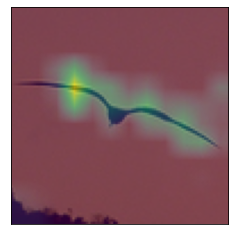

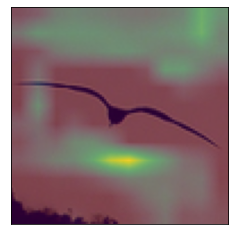

In [24]:
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
import cv2

tf.compat.v1.disable_eager_execution()
K.clear_session()


def plot_any(index, class_id):
    # Disable eager execution
    tf.compat.v1.disable_eager_execution()

    # The first example is a bird
    # Get the output node for class bird
    model = load_model_from_file(base_dir, 'model_2_2')
    my_output = model.output[:, class_id-1]

    # The is the output feature map of the `conv2d_15` layer,
    # the last convolutional layer
    last_conv_layer = model.get_layer('conv2d_15')

    # This is the gradient of the bird class with regard to
    # the output feature map of `conv2d_23`
    grads = K.gradients(my_output, last_conv_layer.output)[0]

    # This is a vector of shape (128,), where each entry
    # is the mean intensity of the gradient over a specific feature map channel
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    # This function allows us to access the values of the quantities we just defined:
    # `pooled_grads` and the output feature map of `block5_conv3`,
    # given a sample image
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

    # Our text example
    x = X_test[index]
    # Turn it into a mini-batch with one example
    x = np.expand_dims(x, axis=0)
    #print(x.shape)

    # Feed it through the network, observe the gradients
    pooled_grads_value, conv_layer_output_value = iterate([x])

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the target class
    for i in range(pooled_grads_value.shape[0]):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation

    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    extent = 0, 8, 0, 8
    fig = plt.figure(frameon=False)
    plt.imshow(np.squeeze(X_test[index]), cmap='gray', extent=extent)
    plt.imshow(heatmap, cmap=plt.cm.viridis, alpha=.6, interpolation='bilinear', extent=extent)
    plt.xticks(()), plt.yticks(())
    
def plot_3_3():
    plot_any(2, 2)
    plot_any(2, 1)
plot_3_3()

answer_q_3_3 = """

In this example, the image is a bird and the activations shown by the heatmap are clearly focussing on the wings. In the second image we show the 
activations on class 'airplane', and the activations there do not react to bird-like wings at all. Other examples of birds (see below) do not focus
onb the wings but rather on the beak. That tells us that the model can learn that birds take on different shaped depending on how we look at them,
yet they still recognize all different 'shapes' well. 
"""

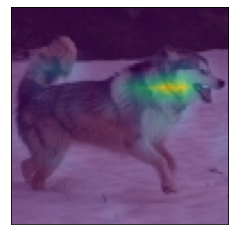

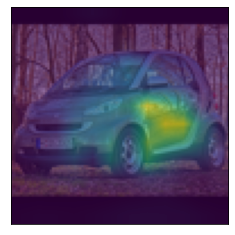

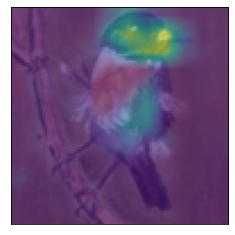

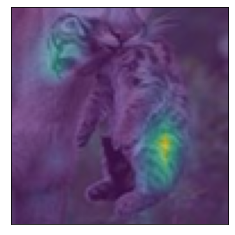

In [25]:
# Other classes
# class_names = ["airplane", "bird", "car", "cat", "deer", "dog", "horse", "monkey", "ship", "truck"]
plot_any(11, 6) # dog, focus on fur, collar?
plot_any(12, 3) # car, focus on wheel rims
plot_any(13, 2) # bird, focus on beak and feather patterns
plot_any(14, 4) # cat, focus on the striped pattern in its fur


## Part 4. Transfer learning (10 points)
### Question 4.1 Transfer learning from VGG16 (5 points)
- Import the VGG16 model, pretrained on ImageNet. [See here](https://keras.io/applications/). Only import the convolutional part, not the dense layers.
- Implement a function 'build_model_4_1` that adds at least one dense hidden layer and output layer to the convolutional base, and freezes the convolutional base. Consider unfreezing the last few convolutional layers, in a systematic way, and evaluate whether that works better. You can also consider adding multiple dense hidden layers and regularization layers.
- Train the resulting model on the augmented training data ('augmented_split').
- Evaluate the resulting model using 'run_evaluate'. Discuss the observed performance in 'answer_q_4_1'.

58892288/58889256 [==============================] - 1s 0us/step
Training the model
Epoch 1/100
130/130 [==============================] - ETA: 0s - batch: 64.5000 - size: 64.0000 - loss: 1.6494 - accuracy: 0.5273WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


130/130 [==============================] - 16s 119ms/step - batch: 64.5000 - size: 64.0000 - loss: 1.6494 - accuracy: 0.5273 - val_loss: 1.4545 - val_accuracy: 0.6476
Epoch 2/100
130/130 [==============================] - 15s 114ms/step - batch: 64.5000 - size: 64.0000 - loss: 1.0475 - accuracy: 0.7172 - val_loss: 1.6959 - val_accuracy: 0.6163
Epoch 3/100
130/130 [==============================] - 15s 118ms/step - batch: 64.5000 - size: 64.0000 - loss: 0.8110 - accuracy: 0.7689 - val_loss: 0.8692 - val_accuracy: 0.7841
Epoch 4/100
130/130 [==============================] - 15s 118ms/step - batch: 64.5000 - size: 64.0000 - loss: 0.6926 - accuracy: 0.7989 - val_loss: 0.7276 - val_accuracy: 0.7933
Epoch 5/100
130/130 [==============================] - 16s 120ms/step - batch: 64.5000 - size: 64.0000 - loss: 0.6145 - accuracy: 0.8175 - val_loss: 0.7750 - val_accuracy: 0.7880
Epoch 6/100
130/130 [==============================] - 15s 119ms/step - batch: 64.5000 - size: 64.0000 - loss: 0.5421

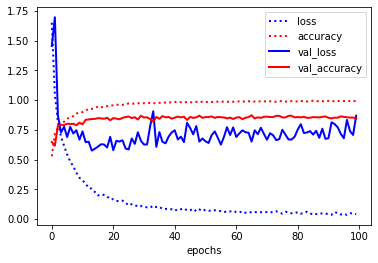

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 3, 512)         2048      
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               1179904   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 15,899,210
Trainable params: 8,262,922
Non-trainable params: 7,636,288
_________________________________________________________________
None
Answer is 895 characters long


In [26]:
from tensorflow.keras.applications.vgg16 import VGG16
from keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator



# evaluation_split = X_train, X_val, y_train, y_val
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False


def build_model_4_1():
    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.BatchNormalization())
    model.add(layers.Flatten())
    model.add(layers.Dense(256, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(layers.Dense(10, activation='sigmoid'))
    model.compile(optimizer=optimizers.Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


augmented_split = evaluation_split
X_train_pre, X_val_pre, y_train_pre, y_val_pre = augmented_split


train_datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
it_train = train_datagen.flow(X_train_pre, y_train_pre, batch_size=64)


augmented_split = it_train, X_val_pre, y_val_pre
run_evaluation("model_4_1", build_model_4_1, augmented_split, base_dir, train=True, 
               generator=True, epochs=100, batch_size=None, steps_per_epoch=X_train_pre.shape[0]//64)



# run_evaluation("model_4_1", build_model_4_1, augmented_split, base_dir, 
#                train=False, epochs=80, batch_size=64)


answer_q_4_1 = """

When we freeze the convolutional base and unfreeze the last convolutional block and train it together with the dense layer, 
the performance of the model on validation set is above 80%. However, the result with our own convolutional network is a
little bit lower than 80%. Note that we are comparing the results on the original dataset without data augmentation. This means 
that the transfer learning model has helped to improve 3% to 5% accuracy on the validation set. The pretrained layers on
the imagenet are helpful with feature extractions. Also, in this example, we did not unfreeze too many pretrained layers since we
do not have a lot of training images. When we have more images for training, we could try to finetune more layers of the pretrained 
model on the new dataset. In this task, we also performed data augmentation to get a better result, above 85% on validation set.
"""

print("Answer is {} characters long".format(len(answer_q_4_1)))

### Question 4.2 Embeddings and pipelines (5 points)
- Generate embeddings of the original images by running them through the trained convolutional part of model_4_1 (without the dense layers) and returning the output. Make sure that the embeddings are stored and submit them with the assignment.
- Implement a function 'generate_pipeline' that returns an scikit-learn pipeline. You can use any non-deep learning technique (eg. SVMs, RFs,...), and preprocessing technique. You can do model selection using the validation set.
- Implement a function 'create_embeddings' that creates and stores the embeddings for the feature data (X_train, X_val, X_test)
- Implement a function 'evaluation_4_2' that loads the embeddings, evaluates your pipeline on the embedded training and test set, and returns the accuracy. 
- Describe what you did and what you observed. Report the obtained accuracy score. Can you beat your best model thus far?

In [27]:
import pickle
import gzip
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


def store_embedding(X, name):  
    """ Stores the given embedding X in a file called name_embedding.p
        You can run this multiple times to store train and test sets separately
    """
    with gzip.open(os.path.join(base_dir, name+'_embedding.p'), 'wb') as file_pi:
        pickle.dump(X, file_pi)
    
def load_embedding(name):
    """ Loads the previously stored embeeding with the given name and returns it
    """
    with gzip.open(os.path.join(base_dir, name+'_embedding.p'), 'rb') as file_pi:
        return pickle.load(file_pi)


def generate_pipeline():
    """ Returns an sklearn pipeline.
    """
    pipe = Pipeline([ ("scaler", StandardScaler()), ("randomforest", RandomForestClassifier(n_estimators=180, max_depth=16, random_state=1)) ])
    return pipe


def evaluation_4_2(y_train, y_test):
    """ Loads the embeddings, and then builds and evaluates a pipeline with the embedded versions of the input data 
    and returns the test set accuracy.
    Keyword arguments:
        y_train -- The training labels
        y_test -- The test labels
    """
    pipe = generate_pipeline()

    train_emb = load_embedding("train_embeddings")
    test_emb = load_embedding("test_embeddings")
    val_emb = load_embedding("val_embeddings")

    y_test_label = y_test.argmax(axis=1)
    y_train_label = y_train.argmax(axis=1)
    y_val_label = y_val.argmax(axis=1)

    train_emb_com = np.concatenate((train_emb, val_emb))
    train_label_com = np.concatenate((y_train_label, y_val_label))

    X_train_trans = train_emb_com.reshape(train_emb_com.shape[0], -1)
    X_test_trans = test_emb.reshape(test_emb.shape[0], -1)
     
    pipe.fit(X_train_trans, train_label_com)
    test_accuracy = pipe.score(X_test_trans, y_test_label) 

    return test_accuracy

def create_embeddings():
    """ Creates and stores all embeddings. This should be run once, in principle. It will 
        Not be called in the assignment validation.
    """
    model = load_model_from_file(base_dir, "model_4_1")
    feature_extraction_model = model.get_layer("vgg16")
    features_train = feature_extraction_model.predict(X_train)
    features_test = feature_extraction_model.predict(X_test)
    features_val = feature_extraction_model.predict(X_val)

    features_train = features_train.reshape(features_train.shape[0], -1)
    features_test = features_test.reshape(features_test.shape[0], -1)
    features_val = features_val.reshape(features_val.shape[0], -1)

    store_embedding(features_train, "train_embeddings")
    store_embedding(features_test, "test_embeddings")
    store_embedding(features_val, "val_embeddings")

test_acc = evaluation_4_2(y_train, y_test)
print("Test accuracy is {:.4f}".format(test_acc))

answer_q_4_2 =  """
                With the extracted features, we could utilize non-deep learning techniques to do further classification. We build a pipeline to train
                and predict. We use the randomforest to implement the classification and standard scale to preprocess the embeddings. Also we use the
                GridSearchCV on the parameters of n_estimators and max_depth. Model selection indicates randomforest classifier can perform better when we 
                set n_estimators 181 and max_depth 16. We find that the result on test set of the model in question 4.1 is 85.7% while the ML model
                can achieve 86.9%, which is a bit higher than the results obtained on deep networks. The main reason is that randomforest classifier 
                can learn many if-then rules based on the image embeddings, which can be more powerful than a dense layer for classification. Note that this
                is not an end-to-end method because we train the deep network first to get a good representation of the data and then apply the random forest
                classifier for classification.
                """

print("Answer is {} characters long".format(len(answer_q_4_2)))

Test accuracy is 0.8627
Answer is 1015 characters long
